# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical [NSE(National Stock Exchange) ](https://www.nseindia.com/products/content/equities/indices/historical_index_data.htm). Only the  NIFTY 50 will be considered for analysis. 

There roughly 365 days of recoreded trading for the mentioned index.

## Present data 

In [9]:
import numpy as np
import pandas as pd #For data processing
import matplotlib.pyplot as plt #For data visualization


from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller


import statsmodels.tsa.api as smt
import statsmodels.api as sm





def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# To show plot next to the code and not in a new window

In [10]:
DATAPATH = 'data/data2014-19.csv'

In [11]:
data = pd.read_csv(DATAPATH)
data.head(10)

,Date,Open,High,Low,Close
0,05-Nov-2014,8351.25,8365.55,8323.50,8338.30
1,07-Nov-2014,8331.85,8360.35,8290.25,8337.00
2,10-Nov-2014,8337.80,8383.05,8304.45,8344.25
3,11-Nov-2014,8354.10,8378.70,8321.85,8362.65
4,12-Nov-2014,8378.90,8415.05,8370.50,8383.30
5,13-Nov-2014,8405.25,8408.00,8320.35,8357.85
6,14-Nov-2014,8360.70,8400.65,8346.80,8389.90
7,17-Nov-2014,8378.40,8438.10,8349.10,8430.75
8,18-Nov-2014,8441.25,8454.50,8407.25,8425.90
9,19-Nov-2014,8440.65,8455.65,8360.50,8382.30


In [12]:
data.shape

(1234, 5)

In [13]:
data.dtypes

Date      object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [14]:
data.head()

,Date,Open,High,Low,Close
0,05-Nov-2014,8351.25,8365.55,8323.50,8338.30
1,07-Nov-2014,8331.85,8360.35,8290.25,8337.00
2,10-Nov-2014,8337.80,8383.05,8304.45,8344.25
3,11-Nov-2014,8354.10,8378.70,8321.85,8362.65
4,12-Nov-2014,8378.90,8415.05,8370.50,8383.30


## Exploratory data analysis (EDA)

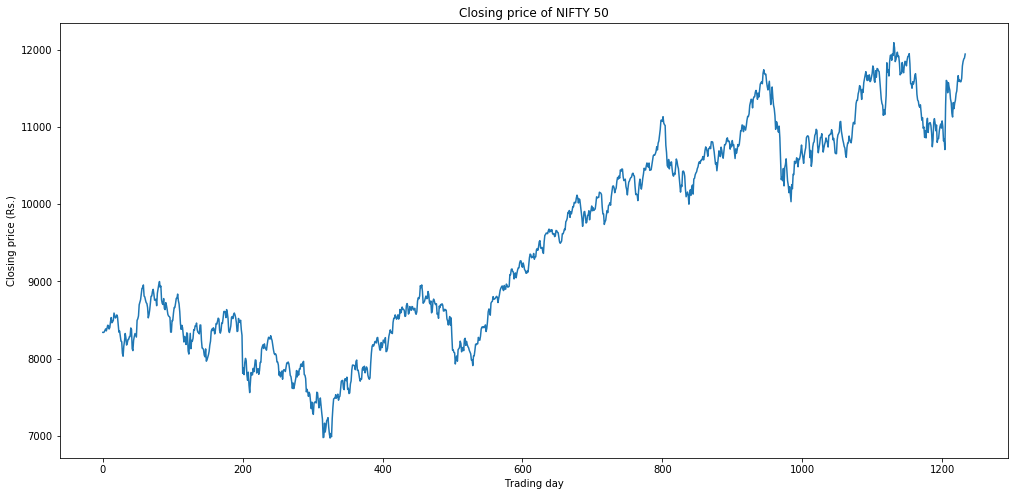

In [15]:
plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of NIFTY 50')
plt.ylabel('Closing price (Rs.)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving average

In [16]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    #To track and identify trends by smoothing normal day to day fluctuations.
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

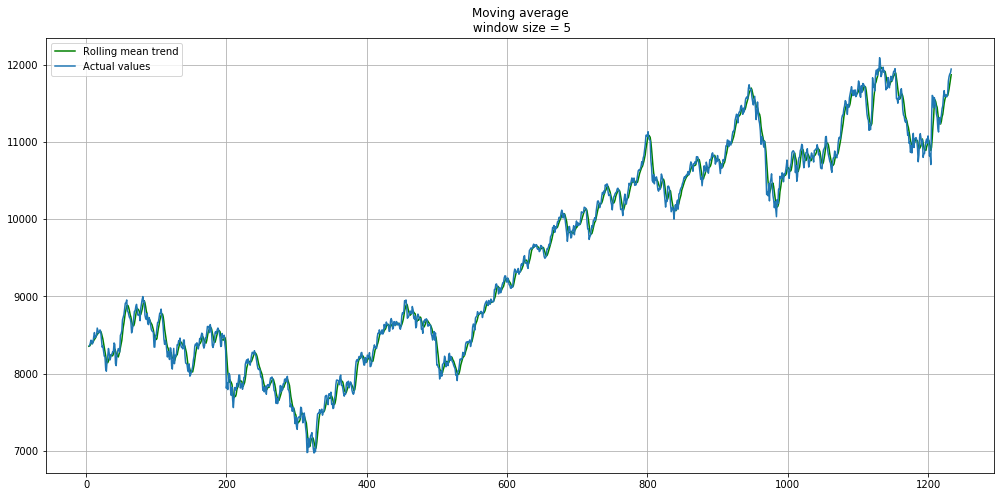

In [17]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)
#plot_moving_average(data.Close, 5,plot_intervals=True)

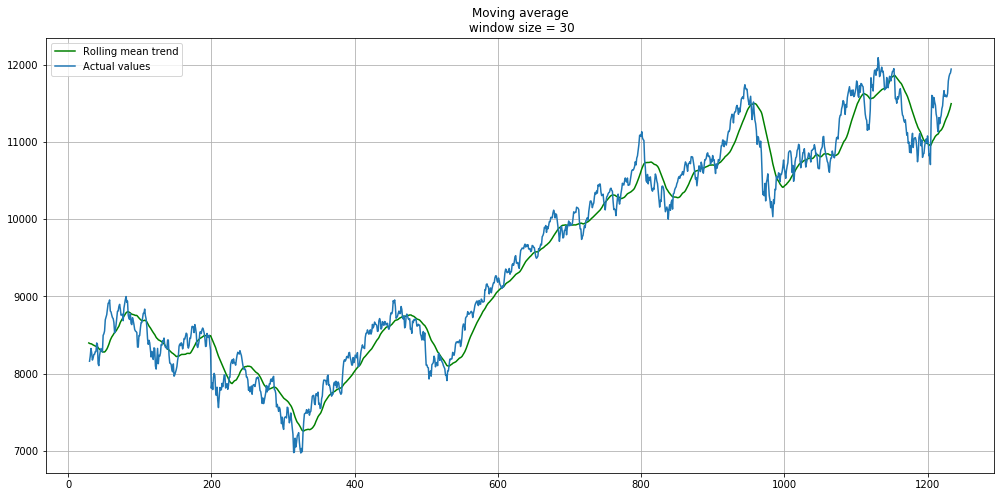

In [18]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

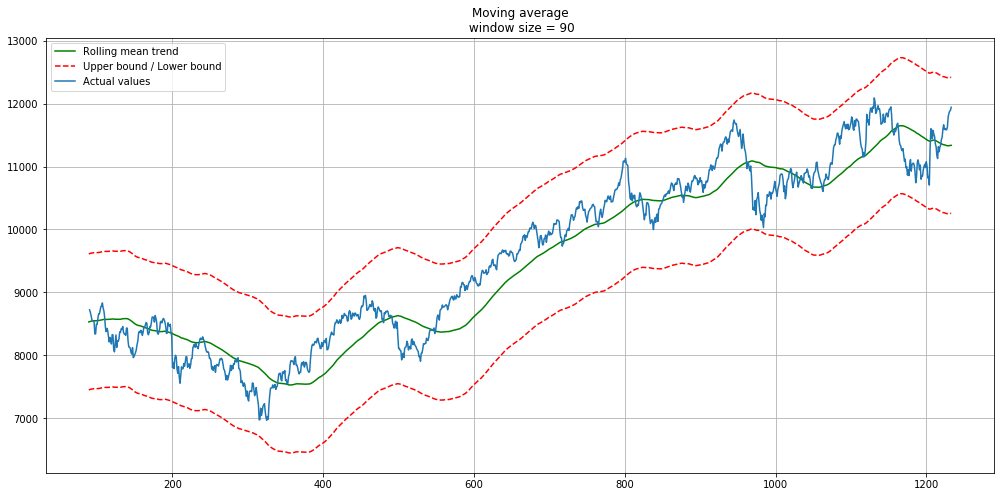

In [19]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

### Exponential smoothing

In [20]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
  
    plt.title("Exponential Smoothing")
    plt.grid(True);

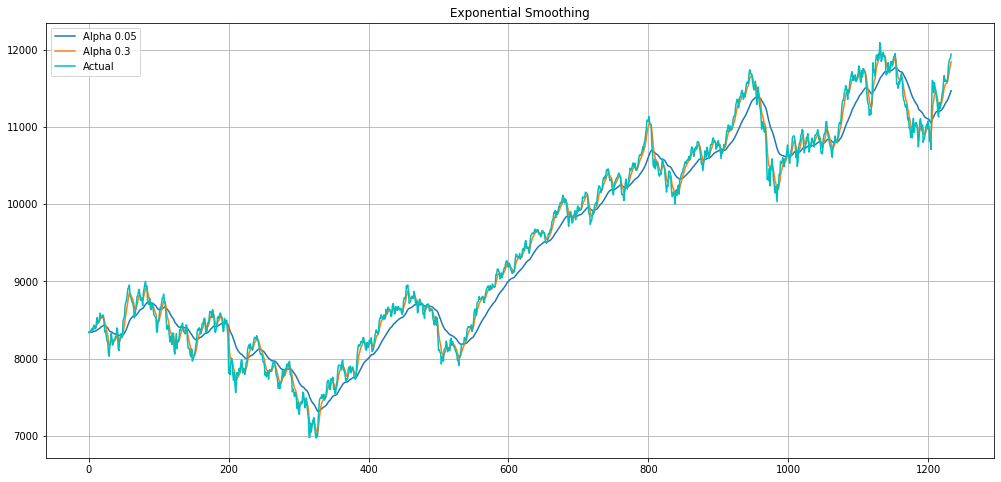

In [22]:
plot_exponential_smoothing(data.Close, [0.05,0.3])

### Double exponential smoothing 

In [23]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [24]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")

    plt.title("Double Exponential Smoothing")
    plt.grid(True)

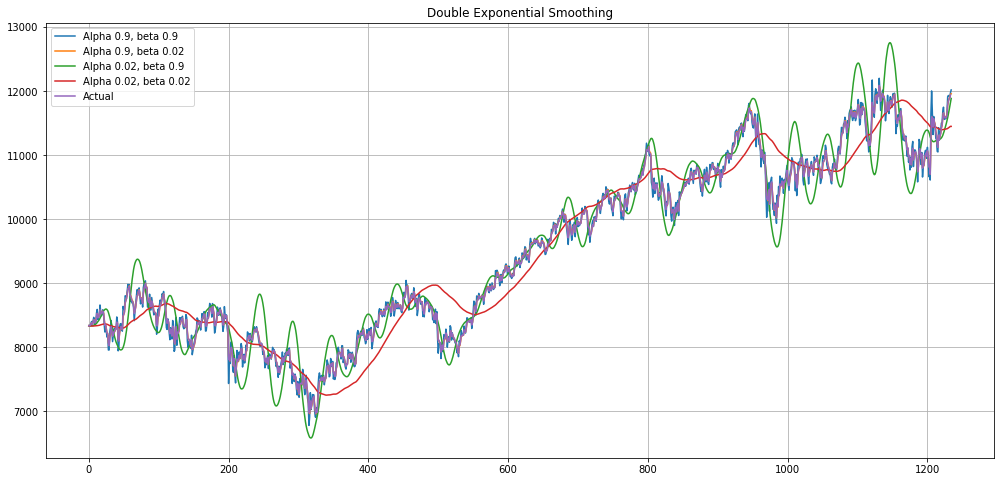

In [25]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity 

In [26]:

dftest = adfuller(data['Close'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','Number Of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test statistic                   -0.571284
p-value                           0.877340
#Lags used                        1.000000
Number Of Observations used    1232.000000
Critical Value (1%)              -3.435669
Critical Value (5%)              -2.863889
Critical Value (10%)             -2.568021
dtype: float64


In [59]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [60]:
differencedSeriesAsList = difference(data.Close)

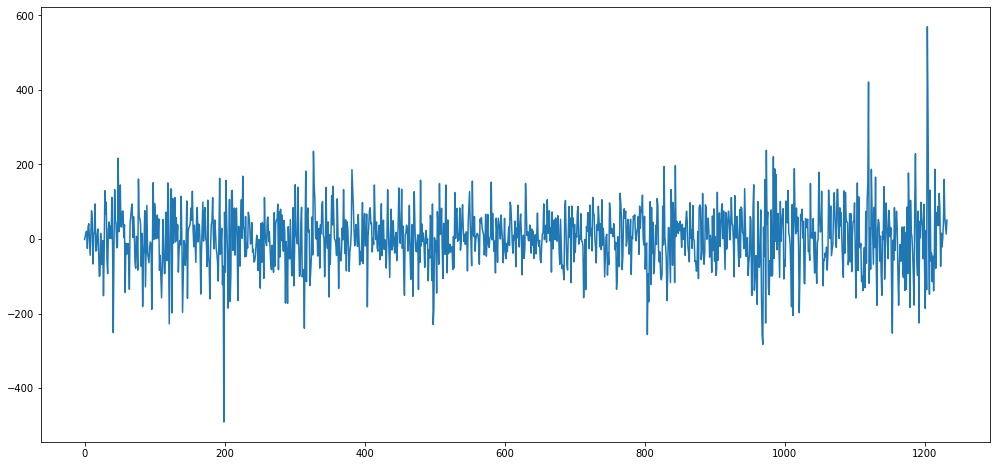

In [61]:
plt.figure(figsize=(17, 8))
plt.plot(differencedSeriesAsList)


In [71]:
dftest = adfuller(differencedSeriesAsList,autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','Number Of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test statistic                  -32.746331
p-value                           0.000000
#Lags used                        0.000000
Number Of Observations used    1232.000000
Critical Value (1%)              -3.435669
Critical Value (5%)              -2.863889
Critical Value (10%)             -2.568021
dtype: float64
